# Automated concrete crack detection for efficient structural assessment
#### Institute of Data Capstone project
#### Simon Leighton, 19 May 2023
  
  
## Introduction

Comprehensive building assessments combined with regular maintenance plays a crucial role in ensuring the long-term stability, safety, and functionality of man-made structures. All buildings require constant maintenance and repairs to offset the damage caused by ageing, weather effects, daily usage, and in extreme cases, natural disasters such as earthquakes. Without proper maintenance, minor issues can escalate into major problems, costing more money to fix, and in some cases compromising structural integrity. By implementing a proactive and comprehensive maintenance plan, building owners and managers can identify and address potential issues early on, preventing costly repairs, minimizing disruptions, and extending the lifespan of the structure.

In recent years, advancements in artificial intelligence (AI) and computer vision have allowed for new possibilities. Convolutional Neural Networks (CNNs), a class of deep learning models specifically designed for image analysis, have emerged as a powerful tool for various computer vision tasks, including object detection, and identifying anomalies. Combining CNNs with recent advancements in robotics and drone technologies allows for new and unique solutions to existing problems. In the context of structural assessment, CNNs offer the potential to quickly and accurately identify concrete cracking in buildings, allowing for targeted intervention and prioritization of repair efforts.

We propose a novel CNN based approach for concrete crack detection in structures. By automating the detection process, we aim to not only reduce the need for human intervention in the identification process, but also potentially remove people from potentially hazardous and difficult to access environments.

In [1]:
# Importing libraries required for modelling

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split

import os
import cv2
import warnings

from google.colab import drive
drive.mount('/content/drive')

warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Creating some variables that point to the saved data and names of the folders that store each of the image classifications.

Setting up random seeds for numpy and keras to ensure that results are reproduceable

In [2]:
# data_directory = r'C:\Users\simon\Documents\Institute of Data\Project 4\Data\Specific' # laptop directory
data_directory = r'/content/drive/Othercomputers/My Laptop/Specific' # google colab directory
folders = ['Uncracked', 'Minor', 'Moderate', 'Severe']
img_size = 128
seed = 314

# Set random seeds
np.random.seed(seed) 
tf.keras.utils.set_random_seed(seed) 

# Set a plotting style
style = {"axes.edgecolor": "white", "grid.color": "lightgrey"}
sns.set_style('white', rc = style)


Creating functions that will be used throughout the modelling process. The functions that will be used are

parse_images: a function for parsing the image data and applying rotations and contrast enchancements. The function returns numpy arrays of normalised image data and one hot encoded labels.

plot_model_curves: a function for plotting the model accuracies and losses to better understand the performance of the model.

model_performance: a function for printing out the model classification report.

model_confusion_mat: a function for plotting the model confusion matrices.

plot_roc: a function for plotting a one vs rest ROC AUC curve for the model classifications. 

display_predictions: a function for plotting a grid of images with their predicted and actual labels.


In [3]:
# Function for parsing the image data
def parse_images(data_directory, img_folders, img_size = 128, contrast = False):
    
    # Create empty lists for the data and labels
    img_data = []
    img_cont = []
    img_labels = []

    # Iterate through all of the images
    for folder in img_folders: # Iterate through the different label folders
        label_int = img_folders.index(folder) # Create an integer for classification 0 = no cracks, 1+ = increasing severity
        path = os.path.join(data_directory, folder) # The file path for the labels
        counter = 0 # Counter to print progress and limit number of samples per label
        
        # Iterate through each image in the file path for the labels
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE) # Create a matrix of the image data in grayscale
            img_resize = cv2.resize(img_array, (img_size, img_size)) # Resize the image to the specified size (128x128 default)
            
            # Rotate the images
            rotation = np.random.randint(4)
            if rotation == 0:
                img_rot = img_resize
            elif rotation == 1:
                img_rot = cv2.rotate(img_resize, cv2.ROTATE_90_CLOCKWISE)
            elif rotation == 2:
                img_rot = cv2.rotate(img_resize, cv2.ROTATE_180)
            else:
                img_rot = cv2.rotate(img_resize, cv2.ROTATE_90_COUNTERCLOCKWISE)

            img_data.append(img_rot) # Append the image data

            # Edit the image contrast
            if contrast == 'full':
                img_cont.append(cv2.equalizeHist(img_rot))
            
            if contrast == 'limited':
                clahe = cv2.createCLAHE(clipLimit = 3.0, tileGridSize=(16, 16))
                img_cont.append(clahe.apply(img_rot))

            # Append the image labels - uncracked = [1, 0, 0, 0], severe = [0, 0, 0, 1]
            img_labels.append([int(folder == f) for f in folders]) 
            
            counter += 1
            if counter == 2400:
                break
            if counter % 100 == 0:
                print(f'{folder}: {counter} images processed')

    # Return the normalised data and labels
    if contrast:
        return np.array(img_data) / 255, np.array(img_cont) / 255, np.array(img_labels) 
    else:
        return np.array(img_data) / 255, np.array(img_labels)
    

# Function for plotting model training curves
def plot_model_curves(history1, title1, mod_name, history2 = False, title2 = False):
    
    # Plot training & validation accuracy values
    plt.figure(figsize = (10, 6))
    sns.lineplot(history1.history['accuracy'], label = f'Train  {title1}')
    sns.lineplot(history1.history['val_accuracy'], label = f'Validation {title1}')
    if history2:
        sns.lineplot(history2.history['accuracy'], ls = '--', color = '#1f77b4', label = f'Train {title2}')
        sns.lineplot(history2.history['val_accuracy'], ls = '--', color = '#ff7f0e', label = f'Validation {title2}')
    plt.title(f'{mod_name} accuracy', fontsize = 14)
    plt.ylabel('Accuracy', fontsize = 10)
    plt.xlabel('Epoch', fontsize = 10)
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    plt.legend(loc = 'lower right', fontsize = 10, handlelength=1.5, handleheight=0.5)
    plt.show()

    # Plot training & validation loss values
    plt.figure(figsize = (10, 6))
    sns.lineplot(history1.history['loss'], label = f'Train  {title1}')
    sns.lineplot(history1.history['val_loss'], label = f'Validation {title1}')
    if history2:
        sns.lineplot(history2.history['loss'], ls = '--', color = '#1f77b4', label = f'Train {title2}')
        sns.lineplot(history2.history['val_loss'], ls = '--', color = '#ff7f0e', label = f'Validation {title2}')
    plt.title(f'{mod_name} loss', fontsize = 14)
    plt.ylabel('Loss', fontsize = 10)
    plt.xlabel('Epoch', fontsize = 10)
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    plt.legend(loc = 'upper right', fontsize = 10, handlelength=1.5, handleheight=0.5)
    plt.show()  

    
# Function for summarising model performance
def model_performance(labels, predictions, title):

    lab = np.argmax(labels, axis = 1)
    pred = np.argmax(predictions, axis = 1)
    print(title, '\n')
    print(classification_report(lab, pred))


# Function for displaying the confusion matrix
def model_confusion_mat(labels, predictions, title):
    lab = np.argmax(labels, axis = 1)
    pred = np.argmax(predictions, axis = 1)

    cm = confusion_matrix(lab, pred)

    sns.heatmap(cm, annot = True, fmt = 'd', annot_kws={'size':10},
                cmap=plt.cm.Greens, linewidths=0.2)
    plt.xticks(ticks = [0.5,1.5,2.5,3.5], labels = folders, fontsize = 10)
    plt.yticks(ticks = [0.5,1.5,2.5,3.5], labels = folders, fontsize = 10)
    plt.xlabel('Predicted label', labelpad = 20)
    plt.ylabel('True label', labelpad = 20)
    plt.title(title, y = 1.05)
    plt.show()


# Function for plotting a one vs rest roc curve
def plot_roc(labels, predictions, title, labels2 = False, predictions2 = False, multi = False):
    
    ### Partial credit to ChatGPT ###
    
    fpr = {}
    tpr = {}
    roc_auc = {}

    fprC = {}
    tprC = {}
    roc_aucC = {}

    for i in range(len(folders)):
        fpr[i], tpr[i], _ = roc_curve(labels[:, i], predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    if multi:
        for i in range(len(folders)):
            fprC[i], tprC[i], _ = roc_curve(labels2[:, i], predictions2[:, i])
            roc_aucC[i] = auc(fprC[i], tprC[i])

    sns.set_palette(sns.color_palette("colorblind", len(folders)))
    roc_style = {"axes.edgecolor": "black"}
    sns.set_style('ticks', rc = roc_style)
    # Plot the ROC curves
    plt.figure()
    for i, folder in enumerate(folders):
        plt.plot(fpr[i], tpr[i], lw=1, label = f'{folder} (AUC = {roc_auc[i]:.2f})')

    if multi:
        for i, folder in enumerate(folders):
            plt.plot(fprC[i], tprC[i], lw=1, ls = '--', label = f'{folder} (contrast adj) (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{title} One-vs-Rest ROC AUC Curve')
    plt.legend(loc="lower right")
    plt.show()
    style = {"axes.edgecolor": "white", "grid.color": "lightgrey"}
    sns.set_style('white', rc = style)

# Function for displaying a selection of predicted labels
def display_predictions(image_data, image_labels, predictions, mod_name):

    indices = np.sort(np.random.choice(len(image_data), size = 12, replace = False)) # Create a list of random indices without replacement
    actual = np.argmax(image_labels, axis = 1)
    pred = np.argmax(predictions, axis = 1)
    plt.figure(figsize=(12, 8))
    for i, index in enumerate(indices):
        plt.subplot(3, 4, i+1) # Plot in a 3x4 grid
        plt.imshow(image_data[index], cmap = 'gray')
        plt.axis('off')
        title = f'Index: {index}\nPredicted: {folders[pred[index]]}\nActual: {folders[actual[index]]}'
        plt.title(title , color = 'g' if pred[index] == actual[index] else 'r', fontsize = 10)
        plt.subplots_adjust(hspace = 0.4)
    plt.suptitle(f'{mod_name} predictions', fontsize = 14, y = .985)
    plt.show()
    


Creating the data that will be used for the modelling process

In [4]:
# Parse the image data

X, XC, y = parse_images(data_directory, folders, contrast = 'limited')

Uncracked: 100 images processed
Uncracked: 200 images processed
Uncracked: 300 images processed
Uncracked: 400 images processed
Uncracked: 500 images processed
Uncracked: 600 images processed
Uncracked: 700 images processed
Uncracked: 800 images processed
Uncracked: 900 images processed
Uncracked: 1000 images processed
Uncracked: 1100 images processed
Uncracked: 1200 images processed
Uncracked: 1300 images processed
Uncracked: 1400 images processed
Uncracked: 1500 images processed
Uncracked: 1600 images processed
Uncracked: 1700 images processed
Uncracked: 1800 images processed
Uncracked: 1900 images processed
Uncracked: 2000 images processed
Uncracked: 2100 images processed
Uncracked: 2200 images processed
Uncracked: 2300 images processed
Minor: 100 images processed
Minor: 200 images processed
Minor: 300 images processed
Minor: 400 images processed
Minor: 500 images processed
Minor: 600 images processed
Minor: 700 images processed
Minor: 800 images processed
Minor: 900 images processe

Now that the image data has been imported, check that the data has been imported correctly by looking at the number of images and the shape of the data.

In [5]:
# Check that the data was imported correctly with the right shape

print(f'{X.shape[0]} images ({X.shape[1]}W x {X.shape[2]}H)')
print(f'{y.shape[1]} labels')

9465 images (128W x 128H)
4 labels


Nearly 9500 images have been imported in the shape of 128x128 pixels. Four different labels have been created which is what we are after.

Moving on to creating a training and test set of data for both the stock and contrast adjusted images. Use the same random seed for both to ensure that the two datasets share identical images. This will allow us to check if the contrast adjusted data is able to perform better.

In [6]:
# Prepare the data for a model and create a train and test set

# Create a train and test split of the data
X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1, img_size, img_size, 1),
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = seed
                                                    )


XC_train, XC_test, yC_train, yC_test = train_test_split(XC.reshape(-1, img_size, img_size, 1),
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = seed
                                                    )


# Delete the original datasets now that we have a train and test split. This is to reduce memory usage
del X, XC

The original X and XC variables were deleted to save memory in the Google colab runtime environment. This is OK since we will only be using the training and tests sets from this point onward in the notebook.

Before moving on to modelling, check the distribution of labels in the training and test datasets to make sure that there isn't a biased distribution. If the distributions aren't even, the model could be trained to predict one label more than others.

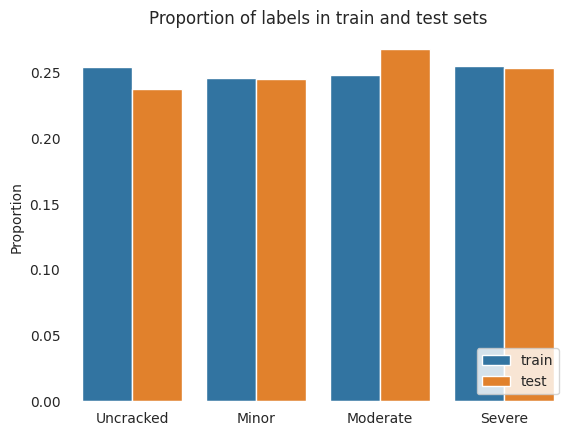

In [7]:
# Plot the distribution of the train and test datasets to check that they are approximately balanced

train_images = np.sum(y_train, axis = 0) / np.sum(y_train)
test_images = np.sum(y_test, axis = 0) / np.sum(y_test)

df = pd.DataFrame({'label': folders, 'train': train_images, 'test': test_images})
df = pd.melt(df, id_vars='label')
sns.barplot(x = 'label', y='value', hue = 'variable', data=df)
plt.xlabel('')
plt.ylabel('Proportion')
plt.title('Proportion of labels in train and test sets')
plt.legend(loc = 'lower right');

The distirbution of labels in the train and test datasets are even and should not bias the model when training. This distribution will be the same for both the stock and contrast adjusted images

## Model 1

Create a first model to check how well a CNN can classify cracked concrete.

Model architecture will be:
Input layer -> Convolutional layer (128 3x3 filters) -> Maxpooling (2x2 grid) -> Convolutional layer (64 3x3 filters) -> Maxpooling (2x2 grid) -> Convolutional layer (32 3x3  layers) -> Maxpooling (2x2 grid) -> Fully connected 256 neuron layer -> Softmax 4 neuron output layer

In [8]:
def create_base_model(X_train, X_test, y_train, y_test, epochs = 25, batch_size = 16):
    
    # Create a Keras Sequential model
    model = Sequential()

    # Add a convolutional layer with 128 filters of size 3x3, padding, relu activation, and an input shape of 128x128x1
    model.add(Conv2D(128, (3,3), padding='same', activation = 'relu', input_shape = X_train.shape[1:]))

    # Add a max pooling layer with a 2x2 pool, strides equal to pool size, and no padding
    model.add(MaxPool2D(pool_size = (2, 2), strides = None, padding = 'valid'))

    # Add a convolutional layer with 64 filters of size 3x3, padding, and relu activation
    model.add(Conv2D(64, (3,3), padding = 'same', activation ='relu'))

    # Add a max pooling layer with a 2x2 pool, strides equal to pool size, and no padding
    model.add(MaxPool2D(pool_size = (2, 2), strides = None, padding = 'valid'))

    # Add a convolutional layer with 32 filters of size 3x3, padding, and relu activation
    model.add(Conv2D(32, (3,3), padding = 'same', activation = 'relu'))

    # Add a max pooling layer with a 2x2 pool, strides equal to pool size, and no padding
    model.add(MaxPool2D(pool_size = (2, 2), strides = None, padding = 'valid'))

    # Flatten the output into a single row
    model.add(Flatten())

    # Create a fully connected dense layer with relu activation
    model.add(Dense(256, activation = 'relu'))

    # Normalise the data to have a mean equal to 0 and std deviation equal to 1
    model.add(BatchNormalization())

    # Provide an output layer the same length as the number of labels to predict with softmax activation
    model.add(Dense(len(folders), activation = 'softmax'))

    # Print out the model summary
    model.summary()

    # Compile the model
    model.compile(loss="categorical_crossentropy", optimizer = Adam(learning_rate = 1e-4), metrics = ["accuracy"]) 

    history = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_split = 0.2, verbose = 1)
    
    predictions = model.predict(X_test)

    return history, predictions, model

Train the models on the stock and adjusted image data

In [9]:
# Create base models on the two different sets of image data

# Create a base model trained and tested with the stock image data
history1, preds1, _ = create_base_model(X_train, X_test, y_train, y_test)

# Create a base model trained and tested with the contrast adjusted data
history1C, preds1C, _ = create_base_model(XC_train, XC_test, yC_train, yC_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 128)     1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0

Plot the model accuracies and losses

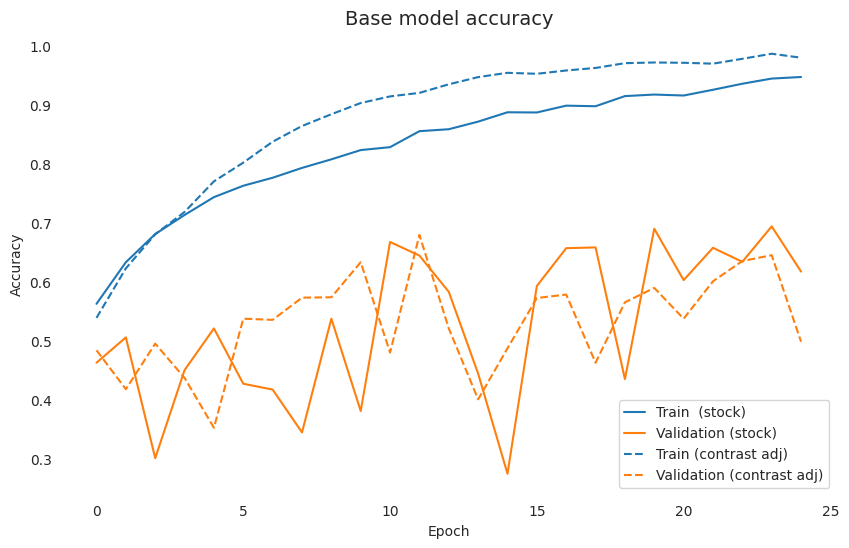

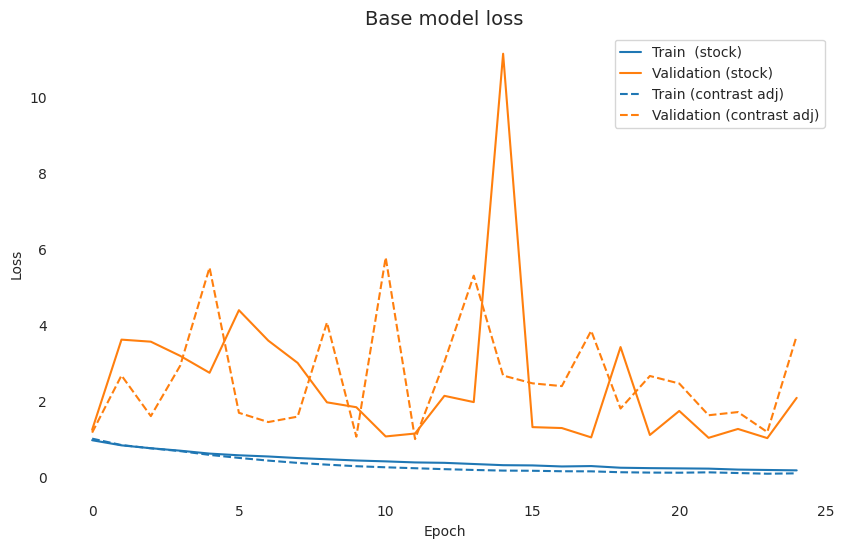

In [10]:
# Plot the learning curves for the two models

plot_model_curves(history1, '(stock)', 'Base model', history1C, '(contrast adj)')

The model gradually gains accuracy on the training data, starting out around 55% and eventually reaching around 95%. The contrast adjusted images gain accuracy faster than the stock data indicating the feature engineering could be making a difference. The validation accuracies are extremely variable for both datasets and there is no clear trend of increasing validation accuracy, implying significant overfitting on the training data. Max validation accuracy is around 65%.

We see a similar result with model losses where the training losses gradually reduce, whereas the validation set varies significantly between epochs.

For the CNN to be useful we will need to significantly improve the performance of the model

In [11]:
# Plot the model scores

# Model with stock image data
model_performance(y_test, preds1, 'Base model - stock images')

# Model with contrast adjusted image data
model_performance(yC_test, preds1C, 'Base model - contrast adjusted images')

Base model - stock images 

              precision    recall  f1-score   support

           0       0.87      0.12      0.20       448
           1       0.42      0.96      0.59       462
           2       0.91      0.44      0.59       505
           3       0.86      0.99      0.92       478

    accuracy                           0.63      1893
   macro avg       0.77      0.62      0.58      1893
weighted avg       0.77      0.63      0.58      1893

Base model - contrast adjusted images 

              precision    recall  f1-score   support

           0       1.00      0.01      0.02       448
           1       0.55      0.16      0.25       462
           2       0.40      0.91      0.56       505
           3       0.77      0.96      0.85       478

    accuracy                           0.53      1893
   macro avg       0.68      0.51      0.42      1893
weighted avg       0.67      0.53      0.43      1893



The contrast adjusted images have perfect precision when predicting uncracked cases. This is very misleading since the model has very low recall, predicting only 1% of the actual uncracked cases. There is significant room for improvement in the models.

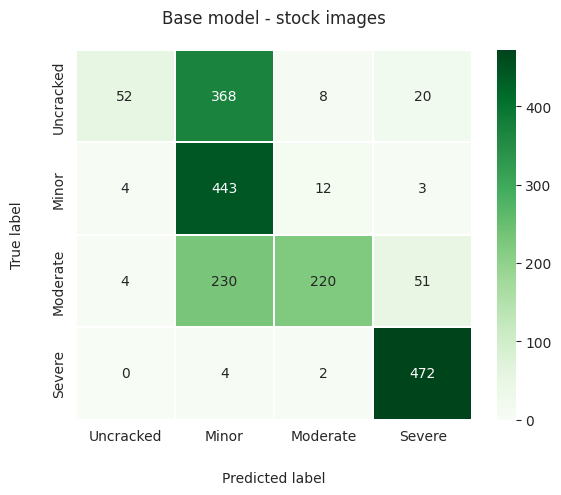

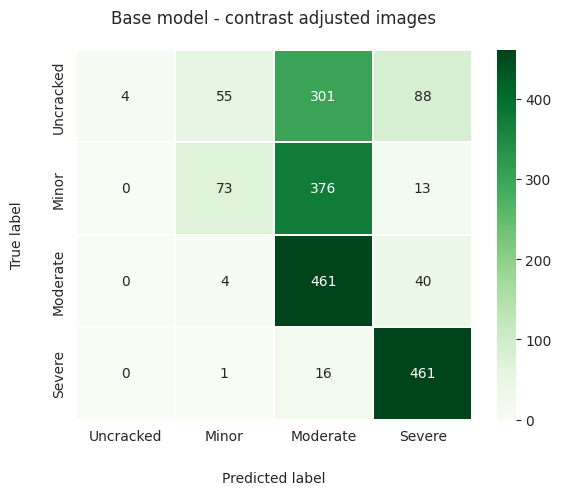

In [12]:
# Plot model confusion matrices

# Model with stock image data
model_confusion_mat(y_test, preds1, 'Base model - stock images')

# Model with contrast adjusted image data
model_confusion_mat(yC_test, preds1C, 'Base model - contrast adjusted images')

We can see that the stock image data model does a good job at predicting severe and minor cases, however is doing a very poor job with moderate and uncracked labels. Interestingly, the contrast adjusted model does a good job at predicting severe and moderate cases, however it does a poor job with minor and uncracked cases.

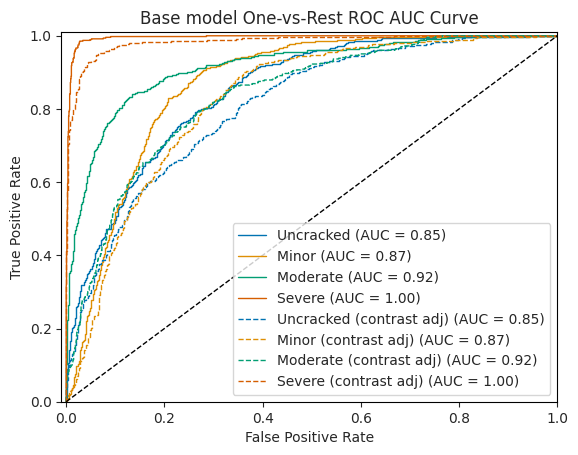

In [13]:
# Plot the ROC curve

plot_roc(y_test, preds1, 'Base model', yC_test, preds1C, multi = True)

The ROC AUC curve shows that the stock image data consistently has a higher probability of being selected over a randomly selected negative variable when compared to contrast adjusted images.

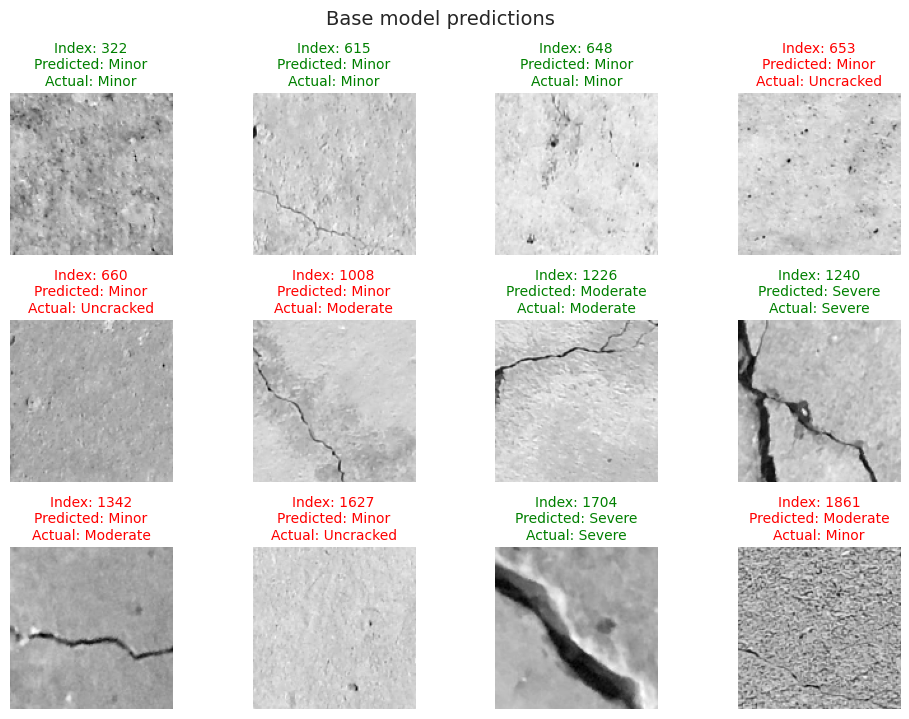

In [14]:
# Plot some of the predicted images

display_predictions(X_test, y_test, preds1, 'Base model')

A random selection of predictions shows that the model is struggling with predictions in multiple areas.

## Model 2

Create a second model to try and improve on the first model.

Model architecture will be:
Input layer -> Convolutional layer (64 3x3 filters) -> Maxpooling (2x2 grid, 20% dropout) -> Convolutional layer (64 3x3 filters) -> Maxpooling (2x2 grid, 20% dropout) -> Convolutional layer (64 3x3  layers) -> Maxpooling (2x2 grid, 20% dropout) -> Fully connected 256 neuron layer -> Softmax 4 neuron output layer

In [15]:
# Create a new model to try and improve upon the base model
# Use dropout after each layer and keep three convolutional layers each with the same number of filters instead of starting high and reducing

def create_model2(X_train, X_test, y_train, y_test, epochs = 25, batch_size = 16):
    
    # Create a Keras Sequential model
    model = Sequential()

    # Add two convolutional layers with 64 filters of size 3x3, padding, relu activation, and an input shape of 128x128x1
    model.add(Conv2D(64, (3,3), padding='same', activation = 'relu', input_shape = X_train.shape[1:]))

    # Add a max pooling layer with a 2x2 pool, strides equal 1, no padding, and 20% dropout
    model.add(MaxPool2D(pool_size = (2, 2), strides = 1, padding = 'valid'))
    model.add(Dropout(0.2))

    # Add convolutional layer with 64 filters of size 3x3, padding, and relu activation
    model.add(Conv2D(64, (3,3), padding = 'same', activation ='relu'))

    # Add a max pooling layer with a 2x2 pool, strides equal to 1, no padding, and 20% dropout
    model.add(MaxPool2D(pool_size = (2, 2), strides = 1, padding = 'valid'))
    model.add(Dropout(0.2))

    # Add convolutional layer with 64 filters of size 3x3, padding, and relu activation
    model.add(Conv2D(64, (3,3), padding = 'same', activation = 'relu'))

    # Add a max pooling layer with a 2x2 pool, strides equal to 1, no padding, and 20% dropout
    model.add(MaxPool2D(pool_size = (2, 2), strides = 1, padding = 'valid'))
    model.add(Dropout(0.2))

    # Flatten the output into a single row
    model.add(Flatten())

    # Create a fully connected dense layer with relu activation
    model.add(Dense(256, activation = 'relu'))

    # Provide 20% dropout for the neurons in the dense layer to try and avoid overfitting
    model.add(Dropout(0.2))

    # Normalise the data to have a mean equal to 0 and std deviation equal to 1
    model.add(BatchNormalization())

    # Provide an output layer the same length as the number of labels to predict with softmax activation
    model.add(Dense(len(folders), activation = 'softmax'))

    # Print out the model summary
    model.summary()

    # Compile the model
    model.compile(loss="categorical_crossentropy", optimizer = Adam(learning_rate = 1e-4), metrics = ["accuracy"]) 

    history = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_split = 0.2, verbose = 1)
    
    predictions = model.predict(X_test)

    return history, predictions, model

Training the model

In [16]:
# Training model 2

# Stock images model
history2, preds2, _ = create_model2(X_train, X_test, y_train, y_test)

# Contrast adjusted images model
history2C, preds2C, _ = create_model2(XC_train, XC_test, yC_train, yC_test)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 64)      640       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 64)     0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 127, 127, 64)      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 127, 127, 64)      36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 126, 126, 64)     0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 126, 126, 64)     

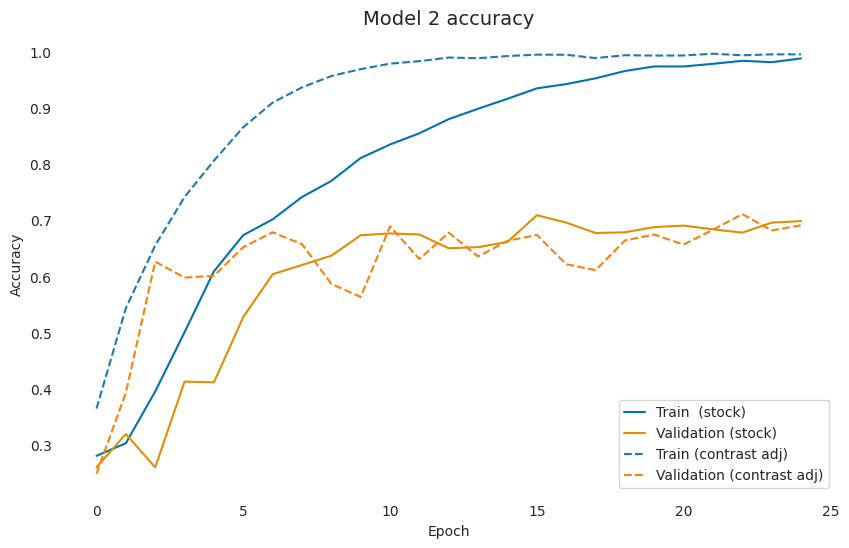

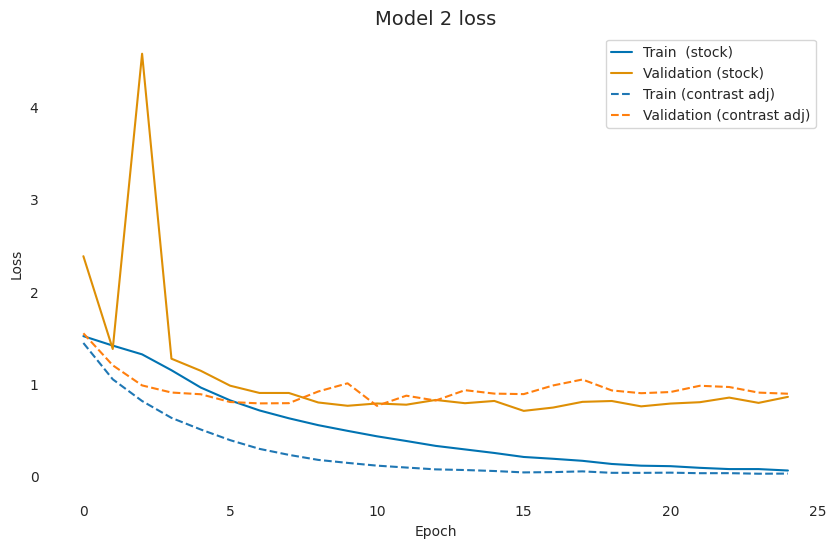

In [17]:
# Plot the learning curves for the two models

plot_model_curves(history2, '(stock)', 'Model 2', history2C, '(contrast adj)')

The contrast adjusted images learn significantly faster than the stock image data before ultimately converging when approaching 100%. Validation accuracy for the contrast adjusted images increases faster than the stock image data before both datasets plateau around 65% within 3 epochs for the contrast adjusted images and 10 epochs for the stock image data. There is noticeable overfitting in the training data as shown in both the accuracy and loss plots with training sets improving while validation sets plateau with a small amount of variation in the plateau. 

In [18]:
# Model with stock image data
model_performance(y_test, preds2, 'Model 2 - stock images')

# Model with contrast adjusted image data
model_performance(y_test, preds2C, 'Model 2 - contrast adjusted images')

Model 2 - stock images 

              precision    recall  f1-score   support

           0       0.65      0.52      0.58       448
           1       0.55      0.60      0.57       462
           2       0.71      0.73      0.72       505
           3       0.92      0.98      0.95       478

    accuracy                           0.71      1893
   macro avg       0.71      0.71      0.71      1893
weighted avg       0.71      0.71      0.71      1893

Model 2 - contrast adjusted images 

              precision    recall  f1-score   support

           0       0.53      0.56      0.55       448
           1       0.59      0.41      0.48       462
           2       0.63      0.77      0.69       505
           3       0.92      0.91      0.92       478

    accuracy                           0.67      1893
   macro avg       0.67      0.66      0.66      1893
weighted avg       0.67      0.67      0.66      1893



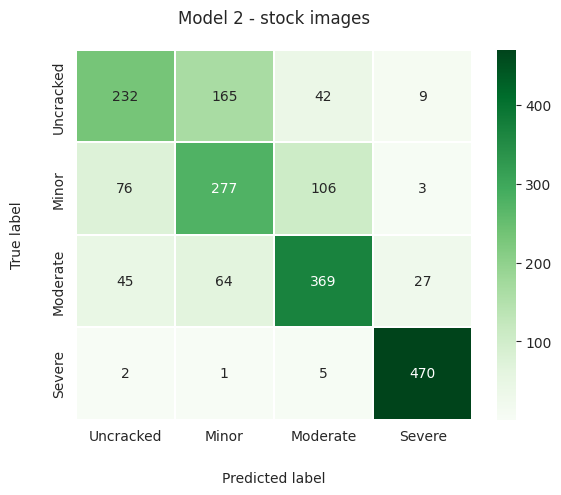

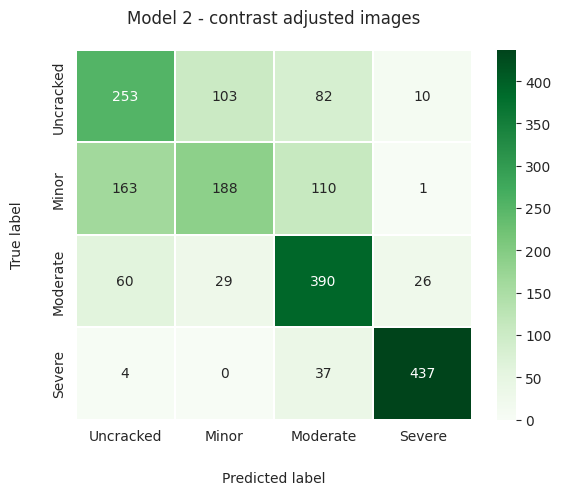

In [19]:
# Model with stock image data
model_confusion_mat(y_test, preds2, 'Model 2 - stock images')

# Model with contrast adjusted image data
model_confusion_mat(yC_test, preds2C, 'Model 2 - contrast adjusted images')

We can see that the model has started to generalise better across all classes as seen by the emergence of a diagonal pattern in the confusion matrices. The contrast aadjusted images are still struggling to classify minor cases. The stock image data is similar but doing a slightly better job that adjusted.

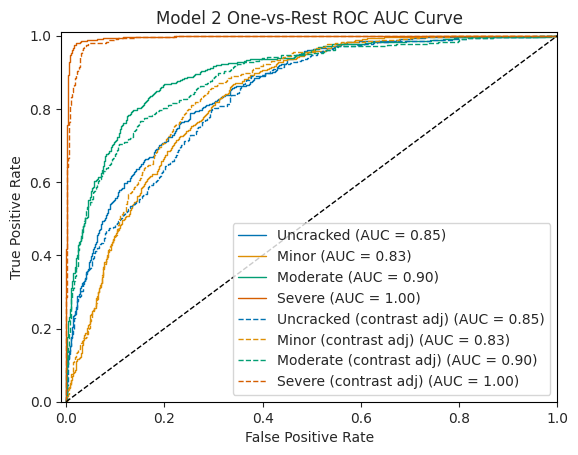

In [20]:
# Plot the ROC curve

plot_roc(y_test, preds2, 'Model 2', yC_test, preds2C, multi = True)

Severe classification continues to perform well with little difference between the two datasets. Minor and uncracked performance is improving toward moderate classification performance. The gap between the probabilities for the two datasets is improving across all labels.

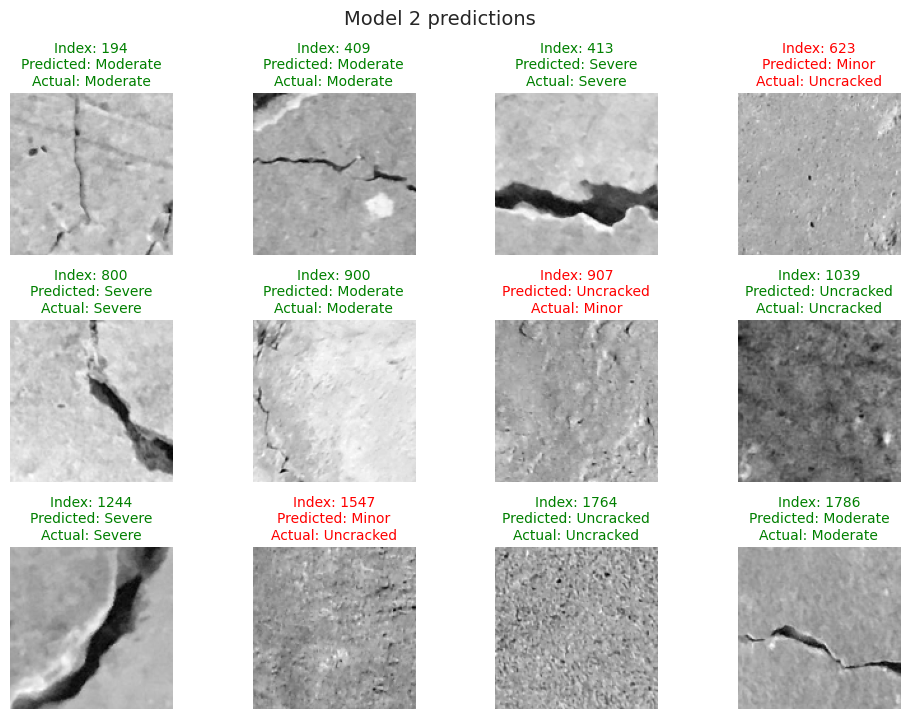

In [21]:
# Plot some of the predicted images

display_predictions(X_test, y_test, preds2, 'Model 2')

All of the randomly selected predictions above are a mix up of minor and uncracked cases.

## Model 3

Create a third model to try and improve on the second model.

Model architecture will be:
Input layer -> Convolutional layer (128 3x3 filters) -> Convolutional layer (128 3x3 filters) -> Maxpooling (2x2 grid, strides = 1, 20% dropout) -> Convolutional layer (64 3x3 filters) -> Convolutional layer (64 3x3 filters) -> Maxpooling (2x2 grid, strides = 1, 20% dropout) -> Convolutional layer (32 3x3 filters) -> Convolutional layer (32 3x3 filters) -> Maxpooling (2x2 grid, strides = 1, 20% dropout) -> Fully connected 256 neuron layer -> Softmax 4 neuron output layer

In [22]:
# Create a new model to try and improve upon model 2
# Add convolutional layers stacked on top of each other without maxpooling in between the layers and reduce the number of filters after each maxpool
# Incorporate strides into the model

def create_model3(X_train, X_test, y_train, y_test, epochs = 25, batch_size = 16):
    
    # Create a Keras Sequential model
    model = Sequential()

    # Add two convolutional layers with 128 filters of size 3x3, padding, relu activation, and an input shape of 128x128x1
    # Do not provide max pooling between these layers to increase the receptive field. Additionally max pooling reduces the resolution of subsequent layers
    model.add(Conv2D(128, (3,3), padding='same', activation = 'relu', input_shape = X_train.shape[1:]))
    model.add(Conv2D(128, (3,3), padding='same', activation = 'relu'))

    # Add a max pooling layer with a 2x2 pool, strides equal 1, no padding, and 20% dropout
    model.add(MaxPool2D(pool_size = (2, 2), strides = 1, padding = 'valid'))
    model.add(Dropout(0.2))

    # Add two convolutional layers with 64 filters of size 3x3, padding, and relu activation
    # Do not provide max pooling between these layers to increase the receptive field. Additionally max pooling reduces the resolution of subsequent layers
    model.add(Conv2D(64, (3,3), padding = 'same', activation ='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation = 'relu'))

    # Add a max pooling layer with a 2x2 pool, strides equal to 1, no padding, and 20% dropout
    model.add(MaxPool2D(pool_size = (2, 2), strides = 1, padding = 'valid'))
    model.add(Dropout(0.2))

    # Add two convolutional layers with 32 filters of size 3x3, padding, and relu activation
    # Do not provide max pooling between these layers to increase the receptive field. Additionally max pooling reduces the resolution of subsequent layers
    model.add(Conv2D(32, (3,3), padding = 'same', activation = 'relu'))
    model.add(Conv2D(32, (3,3), padding = 'same', activation = 'relu'))

    # Add a max pooling layer with a 2x2 pool, strides equal to 1, no padding, and 20% dropout
    model.add(MaxPool2D(pool_size = (2, 2), strides = 1, padding = 'valid'))
    model.add(Dropout(0.2))

    # Flatten the output into a single row
    model.add(Flatten())

    # Create a fully connected dense layer with relu activation
    model.add(Dense(256, activation = 'relu'))

    # Provide 20% dropout for the neurons in the dense layer to try and avoid overfitting
    model.add(Dropout(0.2))

    # Normalise the data to have a mean equal to 0 and std deviation equal to 1
    model.add(BatchNormalization())

    # Provide an output layer the same length as the number of labels to predict with softmax activation
    model.add(Dense(len(folders), activation = 'softmax'))

    # Print out the model summary
    model.summary()

    # Compile the model
    model.compile(loss="categorical_crossentropy", optimizer = Adam(learning_rate = 1e-4), metrics = ["accuracy"]) 

    history = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_split = 0.2, verbose = 1)
    
    predictions = model.predict(X_test)

    return history, predictions, model

Training the model

In [23]:
# Training model 3

# Model with stock image data
history3, preds3, _ = create_model3(X_train, X_test, y_train, y_test)

# Model with contrast adjusted image data
history3C, preds3C, _ = create_model3(XC_train, XC_test, yC_train, yC_test)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 128, 128, 128)     1280      
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 127, 127, 128)    0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 127, 127, 128)     0         
                                                                 
 conv2d_14 (Conv2D)          (None, 127, 127, 64)      73792     
                                                                 
 conv2d_15 (Conv2D)          (None, 127, 127, 64)      36928     
                                                      

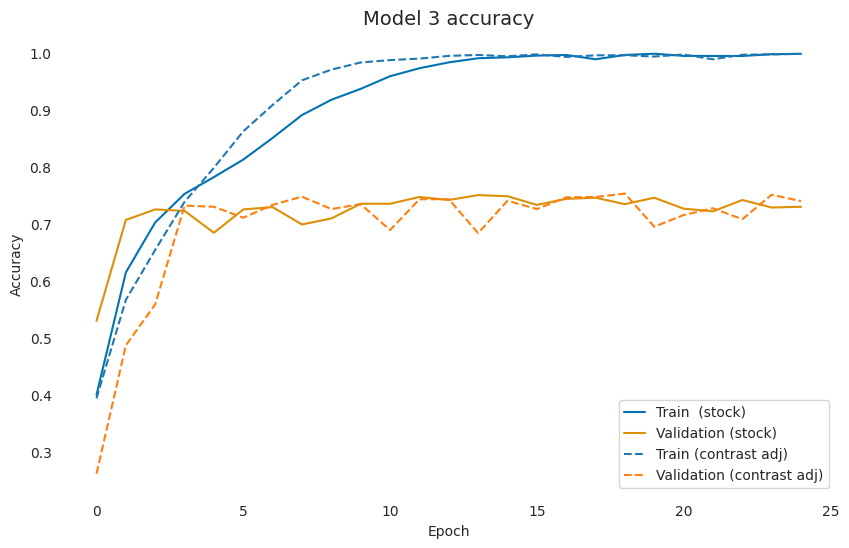

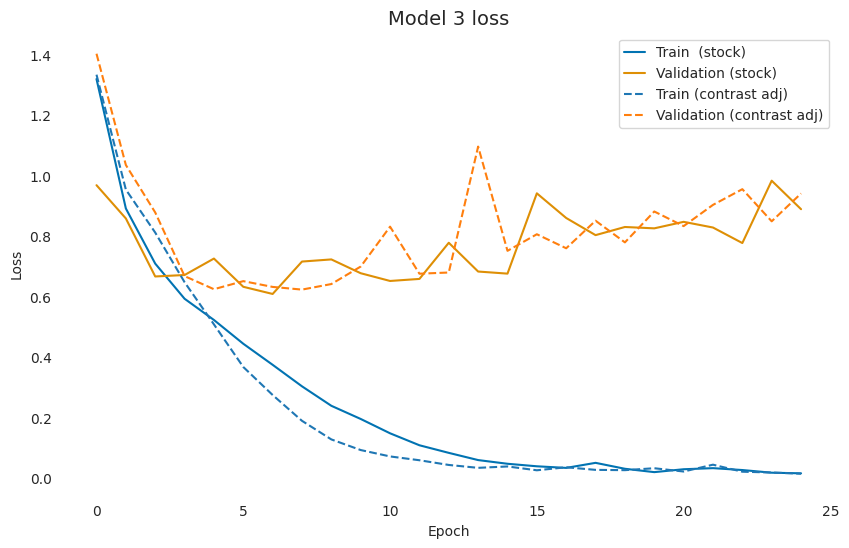

In [24]:
# Plot the learning curves for the two models

plot_model_curves(history3, '(stock)', 'Model 3', history3C, '(contrast adj)')

The model gradually learns on the training data with no significant differences in learning rate between the two datasets. The validation accuracy improves sharply before both datasets reach a plateau around 70% within 3 epochs. This shows the model is overfitting very early on in the learning process, with no real benefit in model performance beyond 5 epochs. The noise in the validation accuracy plateau is significantly reduced with a small boost in performance over model 2 (65% to 70%).

In [25]:
# Model with stock image data
model_performance(y_test, preds3, 'Model 3 - stock images')

# Model with contrast adjusted image data
model_performance(yC_test, preds3C, 'Model 3 - contrast adjusted images')

Model 3 - stock images 

              precision    recall  f1-score   support

           0       0.62      0.53      0.57       448
           1       0.53      0.74      0.62       462
           2       0.91      0.70      0.79       505
           3       0.97      0.97      0.97       478

    accuracy                           0.74      1893
   macro avg       0.76      0.74      0.74      1893
weighted avg       0.76      0.74      0.74      1893

Model 3 - contrast adjusted images 

              precision    recall  f1-score   support

           0       0.58      0.58      0.58       448
           1       0.57      0.61      0.59       462
           2       0.78      0.68      0.73       505
           3       0.91      0.97      0.94       478

    accuracy                           0.71      1893
   macro avg       0.71      0.71      0.71      1893
weighted avg       0.71      0.71      0.71      1893



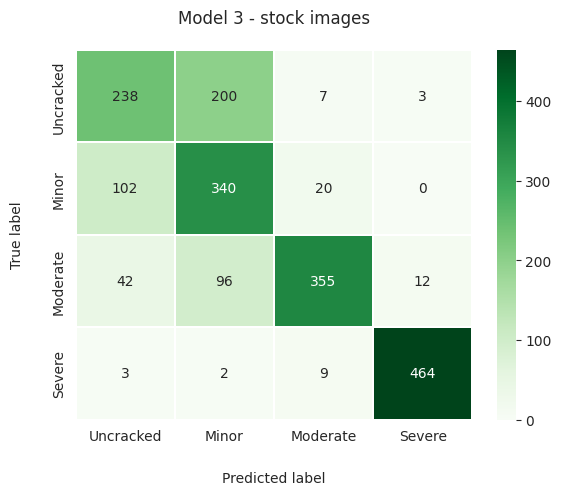

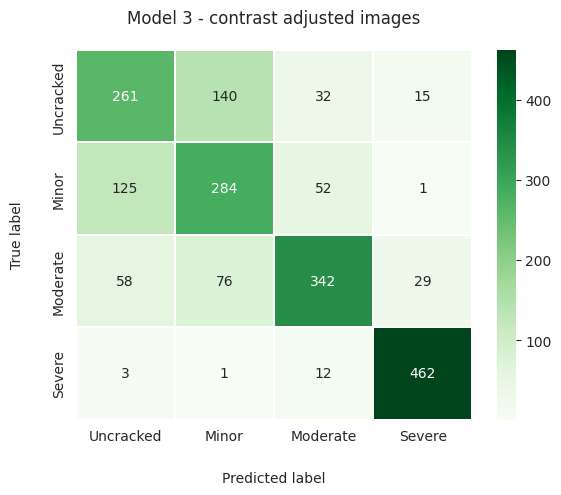

In [26]:
# Model with stock image data
model_confusion_mat(y_test, preds3, 'Model 3 - stock images')

# Model with contrast adjusted image data
model_confusion_mat(yC_test, preds3C, 'Model 3 - contrast adjusted images')

A clearer diagonal is emerging as the model is starting to perform better on predicting the different classes. There is still a fair amount of confusion when trying to decide between uncracked and minor cases. The stock and adjusted datasets appear to be better at predicting minor and uncracked labelling respectively

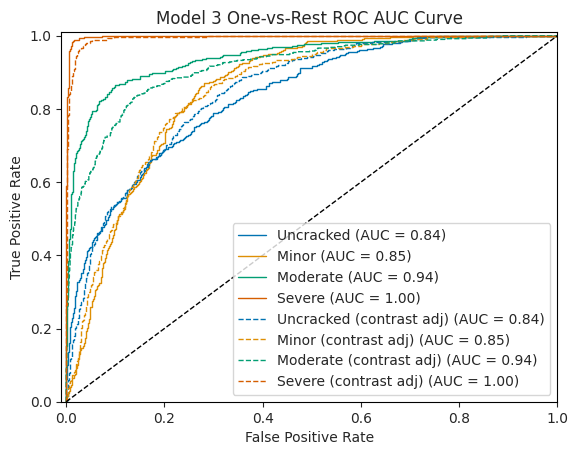

In [27]:
# Plot the ROC curve

plot_roc(y_test, preds3, 'Model 3', yC_test, preds3C, multi = True)

Severe classification continues to perform well with little difference between the two datasets. Minor and uncracked performance is unchanged with no clear preference for neither of the two datasets. The Moderate class is more likely to classify above a randomly chosen negative sample when trained with the stock image data.

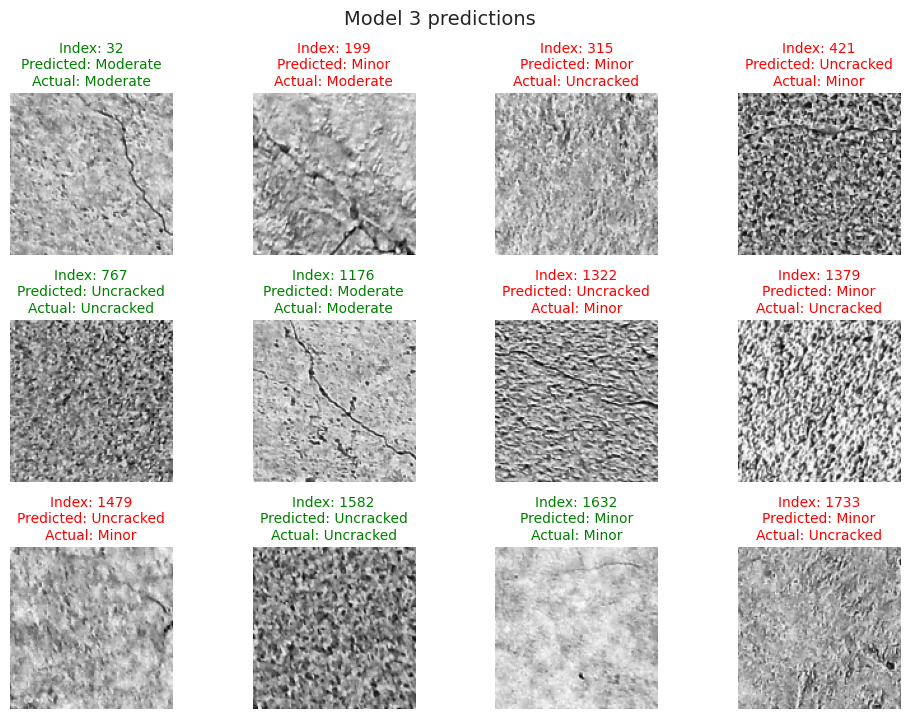

In [28]:
# Plot some of the predicted images

display_predictions(XC_test, yC_test, preds3C, 'Model 3')

The random samples are almost all showing that the model is struggling to identify minor and uncracked cases.

## Model 4

Create a fourth model to try and improve on the third model.

Model architecture will be:
Input layer -> Convolutional layer (64 3x3 filters) -> Convolutional layer (64 5x5 filters, strides = 2) -> Maxpooling (2x2 grid, strides = 1, 20% dropout) -> Convolutional layer (64 3x3 filters) -> Convolutional layer (64 5x5 filters, strides = 2) -> Maxpooling (2x2 grid, strides = 1, 20% dropout) -> Convolutional layer (32 3x3 filters) -> Convolutional layer (64 5x5 filters, strides = 2) -> Maxpooling (2x2 grid, strides = 1, 20% dropout) -> Fully connected 256 neuron layer -> Softmax 4 neuron output layer

In [30]:
# Create a new model to try and improve upon model 3
# Keep subsequent convolutional layers, however keep the number of filters constant throughout the whole model
# Increase the filter size in the second subsequent layer and increase stride size to 2 in each direction

def create_model4(X_train, X_test, y_train, y_test, epochs = 25, batch_size = 16):
    
    # Create a Keras Sequential model
    model = Sequential()

    # Add two convolutional layers with 64 filters of size 3x3, padding, relu activation, and an input shape of 128x128x1
    # Do not provide max pooling between these layers to increase the receptive field. Additionally max pooling reduces the resolution of subsequent layers
    # Increase filter size to 5x5 and strides to 2 in each direction
    model.add(Conv2D(64, (3,3), padding='same', activation = 'relu', input_shape = X_train.shape[1:]))
    model.add(Conv2D(64, (5,5), strides = (2, 2), padding='same', activation = 'relu'))

    # Add a max pooling layer with a 2x2 pool, strides equal 1, no padding, and 20% dropout
    model.add(MaxPool2D(pool_size = (2, 2), strides = 1, padding = 'valid'))
    model.add(Dropout(0.2))

    # Add two convolutional layers with 64 filters of size 3x3, padding, and relu activation
    # Do not provide max pooling between these layers to increase the receptive field. Additionally max pooling reduces the resolution of subsequent layers
    # Increase filter size to 5x5 and strides to 2 in each direction   
    model.add(Conv2D(64, (3,3), padding = 'same', activation ='relu'))
    model.add(Conv2D(64, (5,5), strides = (2, 2), padding='same', activation = 'relu'))

    # Add a max pooling layer with a 2x2 pool, strides equal to 1, no padding, and 20% dropout
    model.add(MaxPool2D(pool_size = (2, 2), strides = 1, padding = 'valid'))
    model.add(Dropout(0.2))

    # Add two convolutional layers with 64 filters of size 3x3, padding, and relu activation
    # Do not provide max pooling between these layers to increase the receptive field. Additionally max pooling reduces the resolution of subsequent layers
    # Increase filter size to 5x5 and strides to 2 in each direction    
    model.add(Conv2D(64, (3,3), padding = 'same', activation = 'relu'))
    model.add(Conv2D(64, (5,5), strides = (2, 2), padding = 'same', activation = 'relu'))

    # Add a max pooling layer with a 2x2 pool, strides equal to 1, no padding, and 20% dropout
    model.add(MaxPool2D(pool_size = (2, 2), strides = 1, padding = 'valid'))
    model.add(Dropout(0.2))

    # Flatten the output into a single row
    model.add(Flatten())

    # Create a fully connected dense layer with relu activation
    model.add(Dense(256, activation = 'relu'))

    # Provide 20% dropout for the neurons in the dense layer to try and avoid overfitting
    model.add(Dropout(0.2))

    # Normalise the data to have a mean equal to 0 and std deviation equal to 1
    model.add(BatchNormalization())

    # Provide an output layer the same length as the number of labels to predict with softmax activation
    model.add(Dense(len(folders), activation = 'softmax'))

    # Print out the model summary
    model.summary()

    # Compile the model
    model.compile(loss="categorical_crossentropy", optimizer = Adam(learning_rate = 1e-4), metrics = ["accuracy"]) 

    history = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_split = 0.2, verbose = 1)
    
    predictions = model.predict(X_test)

    return history, predictions, model

Training the model

In [31]:
# Training model 4

# Model with stock image data
history4, preds4, model4 = create_model4(X_train, X_test, y_train, y_test)

# Model with contrast adjusted image data
history4C, preds4C, model4C = create_model4(XC_train, XC_test, yC_train, yC_test)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 128, 128, 64)      640       
                                                                 
 conv2d_25 (Conv2D)          (None, 64, 64, 64)        102464    
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 63, 63, 64)       0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 63, 63, 64)        0         
                                                                 
 conv2d_26 (Conv2D)          (None, 63, 63, 64)        36928     
                                                                 
 conv2d_27 (Conv2D)          (None, 32, 32, 64)        102464    
                                                      

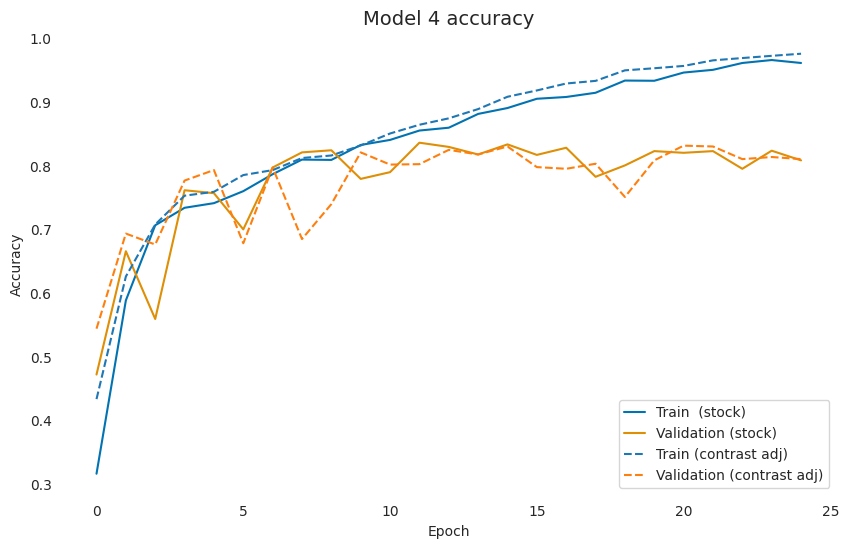

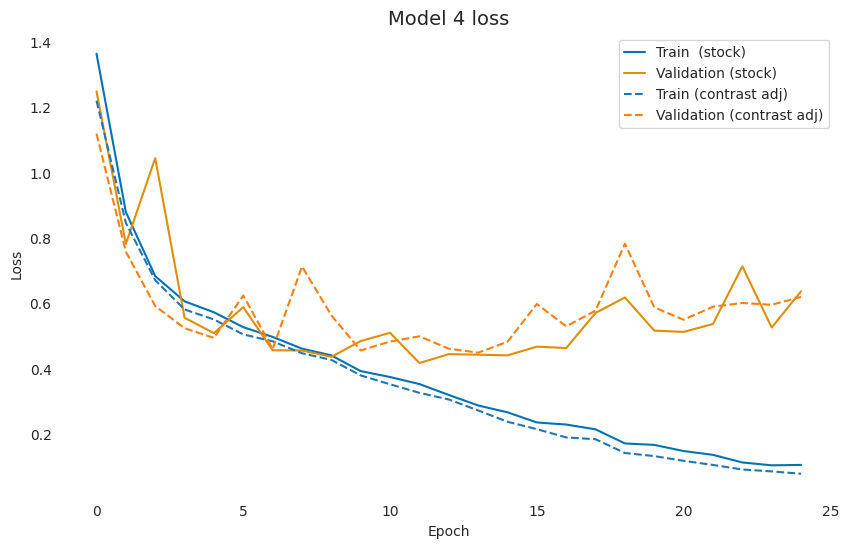

In [33]:
# Plot the learning curves for the two models

plot_model_curves(history4, '(stock)', 'Model 4', history4C, '(contrast adj)')

The training and validation sets have good agreement up to approximately 10 epochs where the model begins to overfit. The model validation accuracy peaks around 80% with no clear preference for the stock or contrast adjusted image data. This is a clear improvement over all of the earlier models and continues to show promise with 80+% accuracy.

In [37]:
# Model with stock image data
model_performance(y_test, preds4, 'Model 4 - stock images')

# Model with contrast adjusted image data
model_performance(yC_test, preds4C, 'Model 4 - contrast adjusted images')

Model 4 - stock images 

              precision    recall  f1-score   support

           0       0.80      0.64      0.71       448
           1       0.63      0.81      0.71       462
           2       0.88      0.82      0.85       505
           3       0.97      0.96      0.96       478

    accuracy                           0.81      1893
   macro avg       0.82      0.81      0.81      1893
weighted avg       0.82      0.81      0.81      1893

Model 4 - contrast adjusted images 

              precision    recall  f1-score   support

           0       0.70      0.79      0.75       448
           1       0.74      0.60      0.67       462
           2       0.85      0.88      0.86       505
           3       0.94      0.97      0.96       478

    accuracy                           0.81      1893
   macro avg       0.81      0.81      0.81      1893
weighted avg       0.81      0.81      0.81      1893



The model is clearly performing better than the previous three models. Precision and recall are still low for the minor and uncracked cases and will need to be improved to be a truly useful model. It is worht investigating if more training data will help the model to learn more complex features

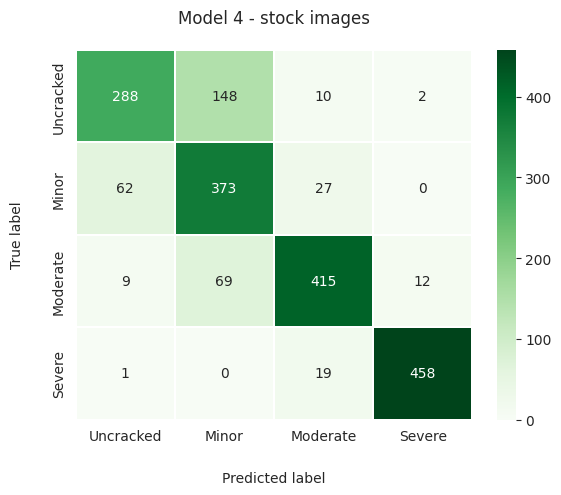

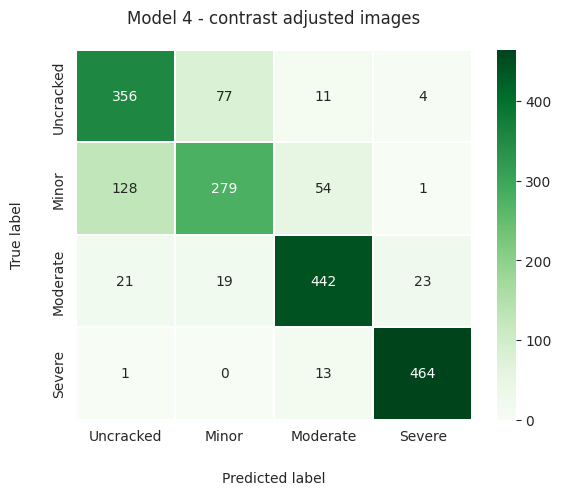

In [38]:
# Model with stock image data
model_confusion_mat(y_test, preds4, 'Model 4 - stock images')

# Model with contrast adjusted image data
model_confusion_mat(yC_test, preds4C, 'Model 4 - contrast adjusted images')

The model performs well however is still struggling to separate uncracked and minor cases. The stock images are better at classifying minor examples, whereas the adjusted data is better at indetifying the uncracked cases. A multi channel would could be useful in separating these two classes.

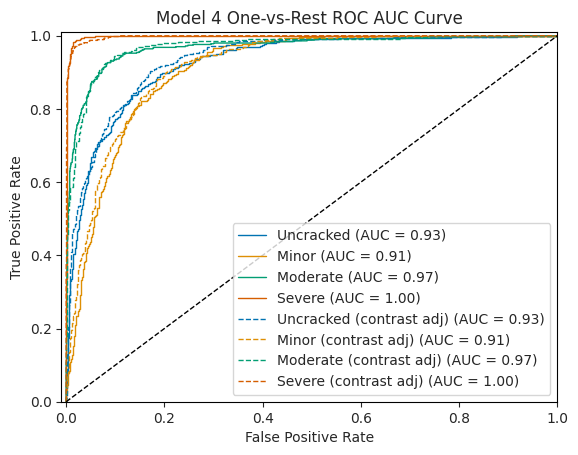

In [ ]:
# Plot the ROC curve

plot_roc(y_test, preds4, 'Model 4', yC_test, preds4C, multi = True)

The model has a greater AUC score for uncracked and minor classes when compared to model three. This is showing a greater probability of ranking a random positive label higher than a random negative label from the other categories.

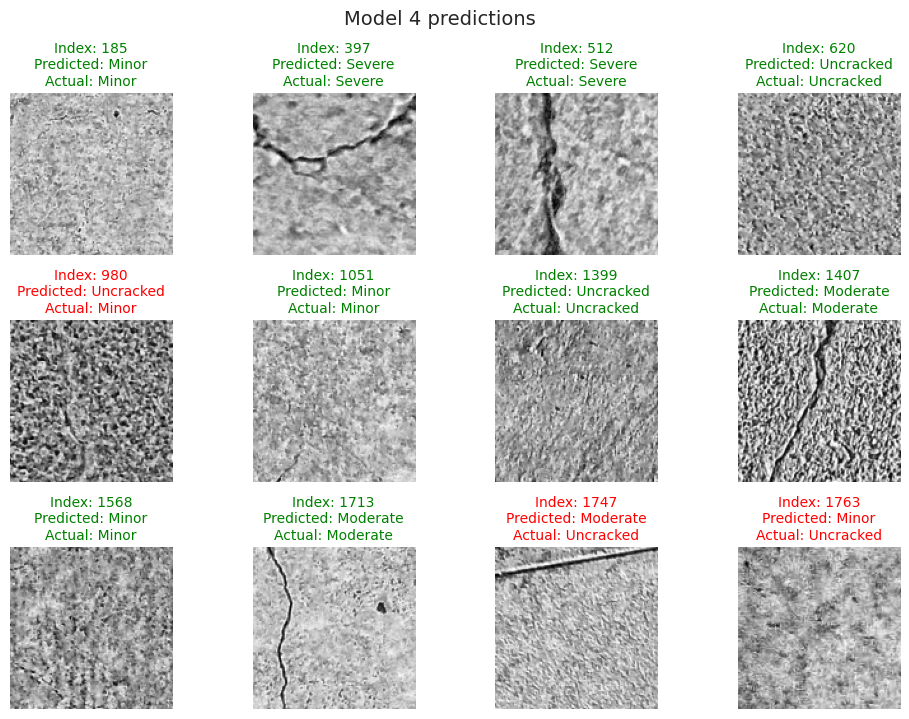

In [40]:
# Plot some of the predicted images

display_predictions(XC_test, yC_test, preds4C, 'Model 4')

The model is still mixing up minor and uncracked cases, and appears to have not yet managed to identify uncracked concrete with saw cuts.

Plotting all model accuracies and losses to compare the results.

In [ ]:
# Plot the model accuracies and losses against each other

plt.figure(figsize = (10, 6))
sns.lineplot(history1.history['val_accuracy'], label = 'Model 1 (stock)')
sns.lineplot(history2.history['val_accuracy'], label = 'Model 2 (stock)')
sns.lineplot(history3.history['val_accuracy'], label = 'Model 3 (stock)')
sns.lineplot(history4.history['val_accuracy'], lw = 2, label = 'Model 4 (stock)')

sns.lineplot(history1C.history['val_accuracy'], ls = '--', label = 'Model 1 (contrast adj)')
sns.lineplot(history2C.history['val_accuracy'], ls = '--', label = 'Model 2 (contrast adj)')
sns.lineplot(history3C.history['val_accuracy'], ls = '--', label = 'Model 3 (contrast adj)')
sns.lineplot(history4C.history['val_accuracy'], ls = '--', lw = 2, label = 'Model 4 (contrast adj)')

plt.title(f'Validation set accuracy', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 10)
plt.xlabel('Epoch', fontsize = 10)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.legend(loc = 'lower right', fontsize = 10, handlelength=1.5, handleheight=0.5)
plt.show()

# Plot training & validation loss values
plt.figure(figsize = (10, 6))
sns.lineplot(history1.history['val_loss'], label = 'Model 1')
sns.lineplot(history2.history['val_loss'], label = 'Model 2')
sns.lineplot(history3.history['val_loss'], label = 'Model 3')
sns.lineplot(history4.history['val_loss'], lw = 2, label = 'Model 4')

sns.lineplot(history1C.history['val_loss'], ls = '--', label = 'Model 1 (cont adjusted)')
sns.lineplot(history2C.history['val_loss'], ls = '--', label = 'Model 2 (cont adjusted)')
sns.lineplot(history3C.history['val_loss'], ls = '--', label = 'Model 3 (cont adjusted)')
sns.lineplot(history4C.history['val_loss'], ls = '--', lw = 2, label = 'Model 4 (cont adjusted)')
plt.title(f'Validation set loss', fontsize = 14)
plt.ylabel('Loss', fontsize = 10)
plt.xlabel('Epoch', fontsize = 10)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.legend(loc = 'upper right', fontsize = 10, handlelength=1.5, handleheight=0.5)
plt.show() 

Model 4 is clearly the best performer between all models. The accuracy, precision, and recall are all improved when compared to the earlier models. The increase in ROC AUC scores shows the model has a greater probability of correctly ranking random postive labels when compared with random negative labels.

# Conclusions and recommendations

The fourth model architecture for our concrete crack detecting CNN has demonstrated promising results. Although the model's accuracy is commendable, there is still room for improvement to enhance its detection capabilities. At this point in time, the model does not have sufficient accuracy to completely replace the role of physical inspection by experts.

There are multiple ways the CNN model could be improved:  
•	Fine-tuning the CNN architecture.  
•	Augmenting the dataset with additional diverse samples.   
•	Further research into feature engineering and image enhancement.  

Despite the room for improvement, the current accuracy level showcases the potential of utilizing CNNs for automated concrete crack detection, offering a valuable tool for building maintenance and assessment. Future research and development efforts should continue to refine and optimize the model to achieve even higher levels of accuracy, thereby ensuring safer and more efficient maintenance practices in the field of structural engineering.



# Slide Background

Make a prediction on the slide background out of curiosity

In [ ]:
slide = ['Slide']

X, XC, _ = parse_images(data_directory, slide, contrast = 'limited')
X = X.reshape(-1, img_size, img_size, 1)

slide_pred = model4.predict(X)
slide_predC = model4C.predict(X_test)

print(f'Slide image stock: {folders[np.argmax(slide_pred)]}')
print(f'Slide image adjusted: {folders[np.argmax(slide_pred)]}')